In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


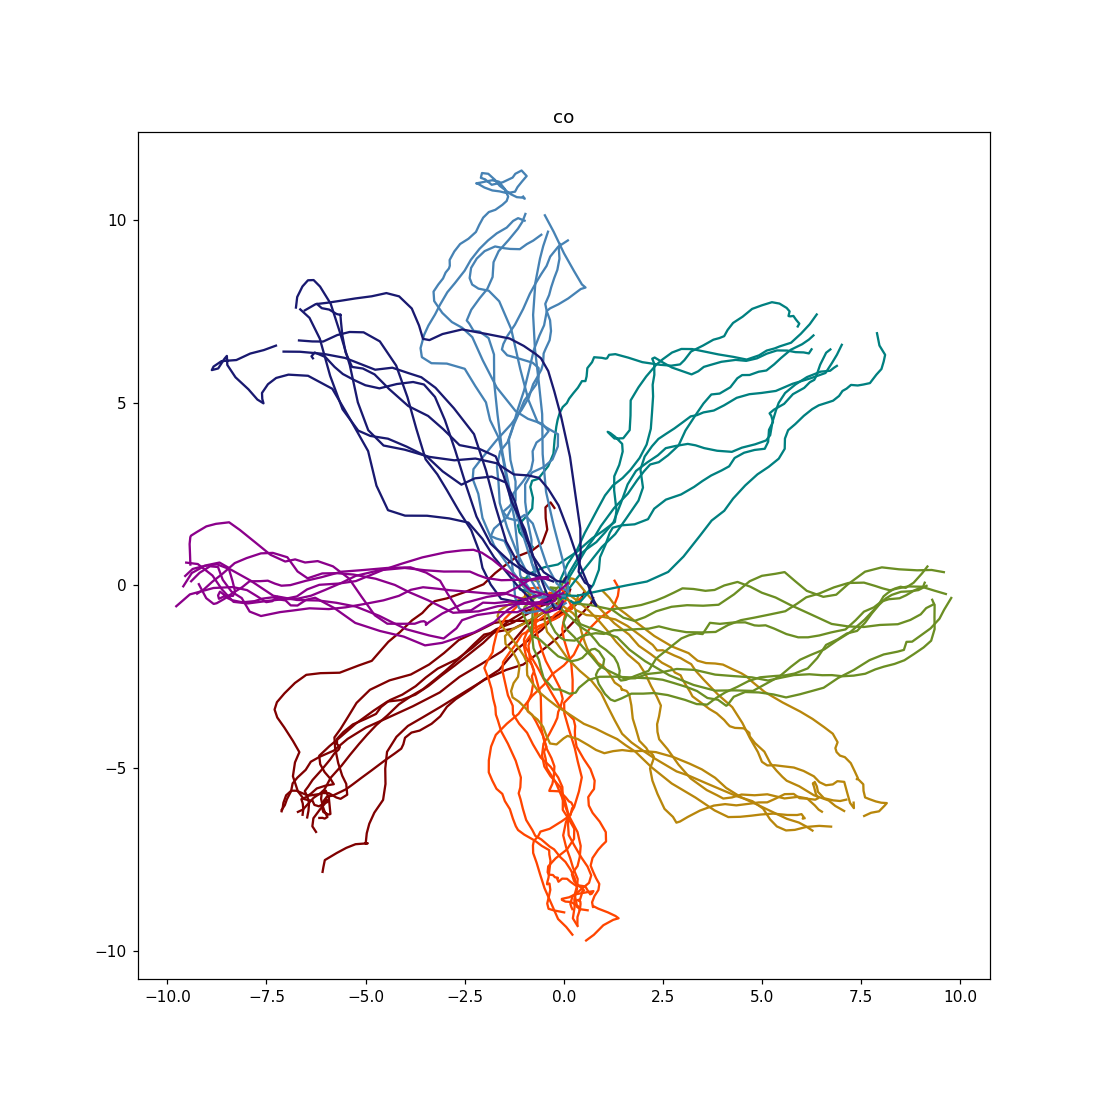

<IPython.core.display.Javascript object>


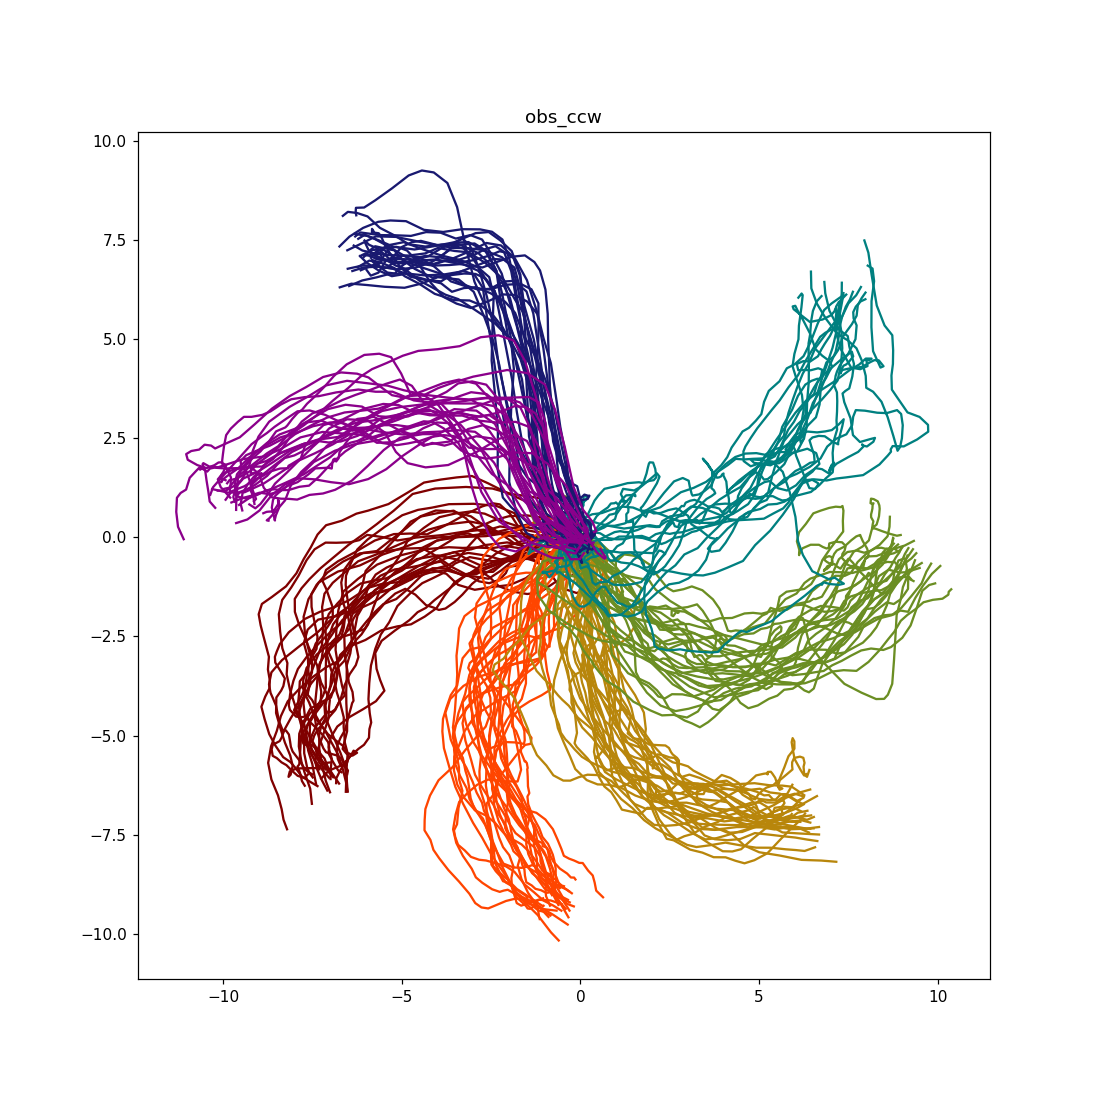

<IPython.core.display.Javascript object>


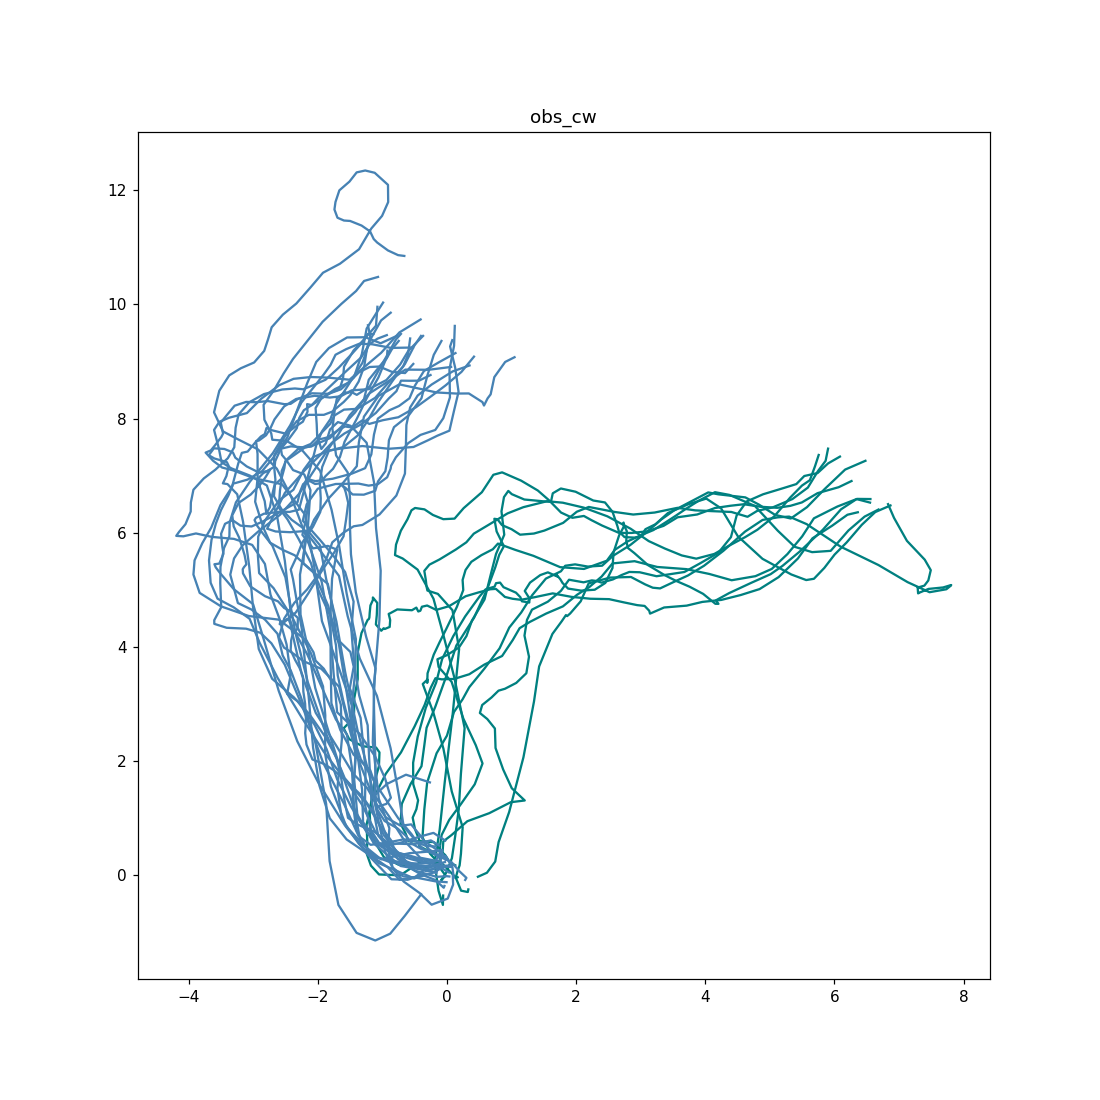

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [7]:
mag_bin_edges

array([[0.01594599, 0.8449011 , 1.32171331, 1.85882319, 3.2226475 ],
       [0.8449011 , 1.32171331, 1.85882319, 3.2226475 , 7.01433267]])

<IPython.core.display.Javascript object>


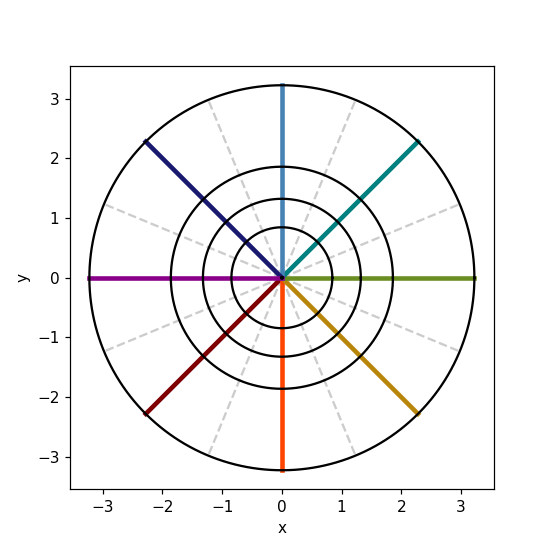

In [8]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Plot an example trial

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


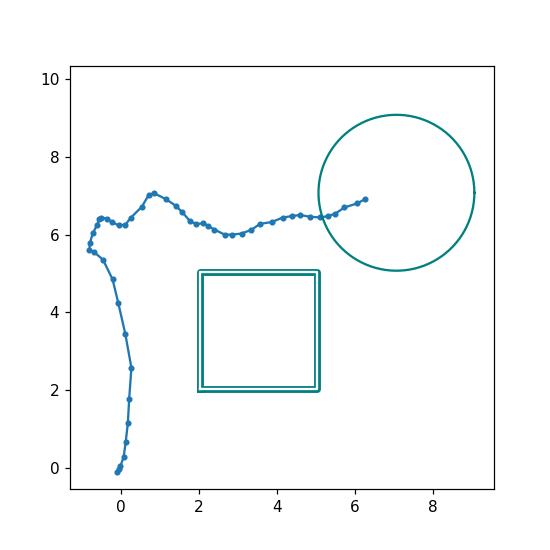

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [9]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Neural dynamics 

In [10]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=2500)
clf.fit(np.array(n_t), np.array(n_tp1))

An = clf.coef_
bn = clf.intercept_

#Put into numpy matrices
An_m = np.mat(An)
bn_m = np.mat(bn).T

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
nhat_tp1 = An_m*n_t_m+bn_m

#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1_m)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('viveks test R2: ', 1-res_var/total_var)
print('true R2: ', clf.score(n_t, n_tp1))

#Calculate mean activity for all neurons @ bin=0 to initialize future simulations: 
sel_bin = (df['bin'] == 0)
n_mean_init = df.loc[sel_bin, n_list].mean()

sanity check on neural dynamics fit:
('viveks test R2: ', 0.24517725254512746)
('true R2: ', 0.2451772525451282)


### Form matrices

In [11]:
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
num_kin = len(kin_var)
offset_var = ['offset']
num_offset = len(offset_var)

#F: 5x5
sel_F = np.array([0,2,3,5,6])
F = decoder['F'][sel_F, :]
F = F[:,sel_F]
print(F.shape)
F = xr.DataArray(F, coords={'out':kin_var+offset_var, 'in':kin_var+offset_var}, dims=['out', 'in'])

#K: 5xnum_neurons
sel_K = np.array([0,2,3,5,6])
Kn = decoder['K'][sel_K, :] #decoder mapping neural to control

(5L, 5L)


In [12]:
#DEFINE DYNAMICS FOR LQR:
A_list, A_dic, B = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)
state_dim = num_neurons+num_kin+1
state_label = n_list+kin_var+offset_var

In [13]:
#DEFINE MOVEMENTS FOR LQR SIMULATION
target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10
move_lqr = bmi_b.def_movements_for_nk_lqr(target_list, task_rot_list, center, target_pos, obs_pos, n_mean_init, obs_margin, waypoint_speed, state_dim, num_neurons)


In [424]:
#DEFINE QR + TASK MODELS:
Qfp_s = 1e7
Qfv_s = Qfp_s
Qp_s = 0
Qv_s = 0
R_s = 1

Q_f, Q, R = bmi_b.def_nk_QR(Qfp_s, Qfv_s, Qp_s, Qv_s, R_s, state_label, state_dim, num_neurons, num_kin, n_list, kin_var, offset_var)
    
task_horizons = {0:40, 1.1:21, 1.2:21} #horizon is double for co than for obs, cuz obs has two phases of control
# task_horizons = {0:60, 1.1:31, 1.2:31} #horizon is double for co than for obs, cuz obs has two phases of control
# task_horizons = {0:80, 1.1:41, 1.2:41} #horizon is double for co than for obs, cuz obs has two phases of control
task_rot_list = [0,1.1,1.2]
#Define the models 
#Models: 
inf_horizon = False
task_models = {}
for task in task_rot_list: 
    T_task = task_horizons[task]
    task_models[task] = bmi_b.def_nk_lqr_models(inf_horizon=False,T=T_task,model_list=A_list,\
                                                A_dic=A_dic, B=B, Q=Q, Q_f=Q_f, R=R)
    


<IPython.core.display.Javascript object>


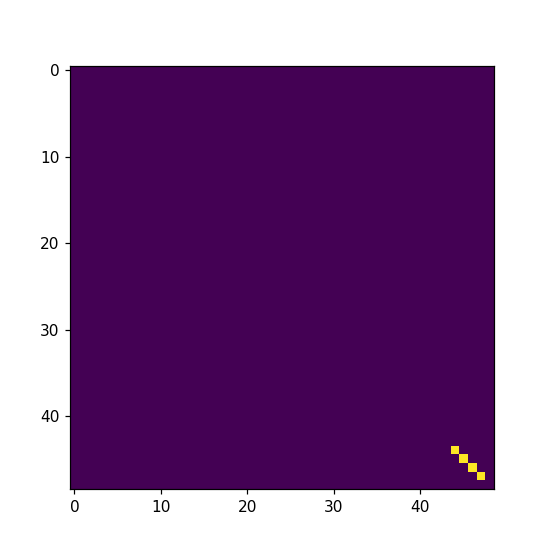

In [425]:
plt.figure(figsize=(5,5))
plt.imshow(Q_f)

In [522]:
#Loop over all movements and simulate lqr for all models: 
input_label = n_list
lqr_sim = {}
for target in target_list:
    for task in task_rot_list:
        for m in task_models[task]:
            print(target, task, m)
            lqr_sim[target,task,m] = {}
            
            #Unpack dynamics, controller, horizon: 
            A = task_models[task][m]['A']
            B = task_models[task][m]['B']
            K = task_models[task][m]['K']
            T = task_models[task][m]['T']
            
            if task > 0: #Obstacle
                #unpack states: 
                state_T = move_lqr[target,task]['state_T']
                state_waypoint = move_lqr[target,task]['state_waypoint']
                state_init = move_lqr[target,task]['state_init']
                
                #obstacle sim
                u_da, state_da, state_e_da, sim_len, h0, h1 = \
                bmi_b.sim_lqr_nk_obs_trial(A,B,K,T, state_T, state_waypoint, state_init, state_label, input_label,\
                                           num_neurons, max_iter=1e5, hold_req=2, target_r=1.7)                
            else: 
                #unpack states: 
                state_T = move_lqr[target,task]['state_T']
                state_init = move_lqr[target,task]['state_init']
                
                #center-out sim
                u_da, state_da, state_e_da, sim_len = \
                bmi_b.sim_lqr_nk_co_trial_finite_horizon(A,B,K,\
                T,state_T, state_init, state_label, input_label, num_neurons, max_iter=1e5, hold_req=2, target_r=1.7)
            #assign:
            lqr_sim[target,task,m]['u_da'] = u_da
            lqr_sim[target,task,m]['state_da'] = state_da
            lqr_sim[target,task,m]['state_e_da'] = state_e_da
            lqr_sim[target,task,m]['sim_len'] = sim_len
            if task>0:
                lqr_sim[target,task,m]['h0'] = h0
                lqr_sim[target,task,m]['h1'] = h1

(0, 0, 'n_null')
(0, 0, 'n_do')
(0, 0, 'n_o')
(0, 1.1, 'n_null')
(0, 1.1, 'n_do')
(0, 1.1, 'n_o')
(0, 1.2, 'n_null')
(0, 1.2, 'n_do')
(0, 1.2, 'n_o')
(1, 0, 'n_null')
(1, 0, 'n_do')
(1, 0, 'n_o')
(1, 1.1, 'n_null')
(1, 1.1, 'n_do')
(1, 1.1, 'n_o')
(1, 1.2, 'n_null')
(1, 1.2, 'n_do')
(1, 1.2, 'n_o')
(2, 0, 'n_null')
(2, 0, 'n_do')
(2, 0, 'n_o')
(2, 1.1, 'n_null')
(2, 1.1, 'n_do')
(2, 1.1, 'n_o')
(2, 1.2, 'n_null')
(2, 1.2, 'n_do')
(2, 1.2, 'n_o')
(3, 0, 'n_null')
(3, 0, 'n_do')
(3, 0, 'n_o')
(3, 1.1, 'n_null')
(3, 1.1, 'n_do')
(3, 1.1, 'n_o')
(3, 1.2, 'n_null')
(3, 1.2, 'n_do')
(3, 1.2, 'n_o')
(4, 0, 'n_null')
(4, 0, 'n_do')
(4, 0, 'n_o')
(4, 1.1, 'n_null')
(4, 1.1, 'n_do')
(4, 1.1, 'n_o')
(4, 1.2, 'n_null')
(4, 1.2, 'n_do')
(4, 1.2, 'n_o')
(5, 0, 'n_null')
(5, 0, 'n_do')
(5, 0, 'n_o')
(5, 1.1, 'n_null')
(5, 1.1, 'n_do')
(5, 1.1, 'n_o')
(5, 1.2, 'n_null')
(5, 1.2, 'n_do')
(5, 1.2, 'n_o')
(6, 0, 'n_null')
(6, 0, 'n_do')
(6, 0, 'n_o')
(6, 1.1, 'n_null')
(6, 1.1, 'n_do')
(6, 1.1, 'n_o')
(6

In [523]:
#Collect norm_u results: 
columns = ['norm_u', 'target', 'task', 'model']
num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
for target in target_list:
    for task in task_rot_list:
        for m in task_models[task]:
            df_i = copy.deepcopy(nan_df)
            df_i['norm_u'] = np.linalg.norm(lqr_sim[target,task,m]['u_da'])
            df_i['target'] = target
            df_i['task'] = task
            df_i['model'] = m
            
            df_list.append(df_i)
lqr_df = pd.concat(df_list, ignore_index=True)

<IPython.core.display.Javascript object>


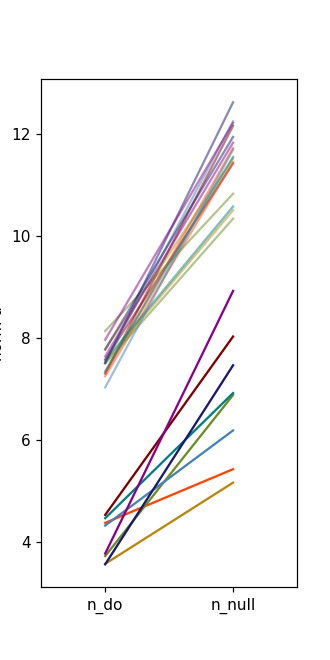

(-0.5, 1.5)

In [524]:
#Plot norm u for all movements: 
# model_list = ['n_do', 'n_o', 'n_null']
model_list = ['n_do', 'n_null']
task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
plt.figure(figsize=(3,6))
for target in target_list:
    for task in task_rot_list:
        
        x_plot = []
        y_plot = []
        for i,m in enumerate(model_list):
            x_plot.append(i)
            sel = \
            (lqr_df['target']==target)\
            &(lqr_df['task']==task)\
            &(lqr_df['model']==m)
            y_i = float(lqr_df.loc[sel,'norm_u'])
            y_plot.append(y_i)
            
        plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

plt.xticks(range(len(model_list)), model_list)
plt.ylabel('norm u')
plt.xlim([-0.5,1.5])

### Inspect individual movements: 

In [540]:
task = 1.2
target = 2

A = task_models[task]['n_do']['A']
B = task_models[task]['n_do']['B']
state_waypoint = move_lqr[target, task]['state_waypoint']

u_star = np.linalg.pinv(B)*(np.eye(state_dim)-A)*state_waypoint

In [541]:
state_waypoint

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

In [542]:
(A*state_waypoint+B*u_star)

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

In [543]:
state_waypoint-(A*state_waypoint+B*u_star)

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

In [546]:
move_lqr[target,task]['state_waypoint'][num_neurons:num_neurons+2]

matrix([[7.77817459],
        [0.70710678]])

In [548]:
waypoint_da = xr.DataArray(move_lqr[target,task]['state_waypoint'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]},\
                           dims=['v', 'obs'])

In [549]:
waypoint_da

<xarray.DataArray (v: 49, obs: 1)>
array([[ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 7.778175],
       [ 0.707107],
       [ 7.071068],
       [-7.071068],
     

In [551]:
waypoint_da.loc[kin_var,0]

<xarray.DataArray (v: 4)>
array([ 7.778175,  0.707107,  7.071068, -7.071068])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [552]:
move_lqr[target,task].keys()

['state_T', 'state_init', 'state_waypoint']

In [554]:
task_models[task]['n_null'].keys()

['A', 'Q_f', 'B', 'K', 'Q', 'R', 'T']

<IPython.core.display.Javascript object>


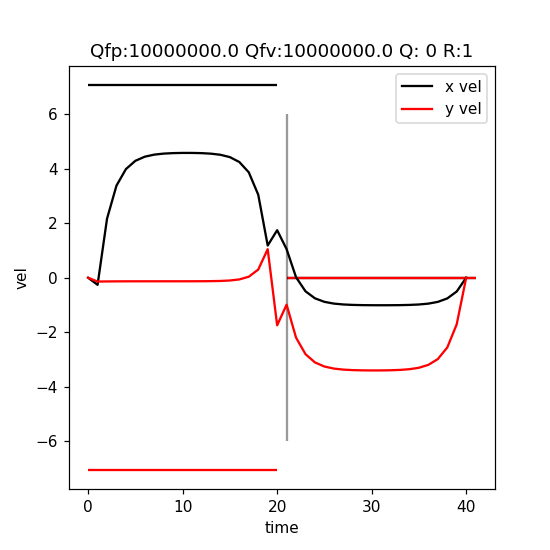

Text(0.5,1,'Qfp:10000000.0 Qfv:10000000.0 Q: 0 R:1')

In [559]:
#For one movement and model, plot diagnostics: 
target = 2
task = 1.2 #1.2
m = 'n_null'

A = task_models[task][m]['A']
B = task_models[task][m]['B']
K = task_models[task][m]['K']
T = task_models[task][m]['T']

sim_len = lqr_sim[target,task,m]['sim_len']
state_da = lqr_sim[target,task,m]['state_da']
state_e_da = lqr_sim[target,task,m]['state_e_da']

#Get waypoint target position and velocity: 
waypoint_da = xr.DataArray(move_lqr[target,task]['state_waypoint'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]},\
                           dims=['v', 'obs'])

target_da = xr.DataArray(move_lqr[target,task]['state_T'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]},\
                           dims=['v', 'obs'])


#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#VELOCITY PLOT
plt.figure(figsize=(5,5))
x = state_da.loc['kin_vx',:]
y = state_da.loc['kin_vy',:]        
plt.plot(x,'-', alpha=1, label='x vel', color=kin_color['x']) # label=k
plt.plot(y,'-', alpha=1, label='y vel', color=kin_color['y'])
plt.hlines(waypoint_da.loc['kin_vx', 0], 0, T-1, color=kin_color['x']) #label='wp x'
plt.hlines(waypoint_da.loc['kin_vy', 0], 0, T-1,color=kin_color['y'])# label='wp y'

plt.hlines(target_da.loc['kin_vx', 0], T, 2*T-1, color=kin_color['x']) #label='wp x'
plt.hlines(target_da.loc['kin_vy', 0], T, 2*T-1,color=kin_color['y'])# label='wp y'
plt.vlines(T, -6, 6,color='k',alpha=0.4)# label='wp y'

plt.xlabel('time')
plt.ylabel('vel')
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  



In [ ]:
#Plot each on the same subplot
#Visualize results: 
target = 2
task = 1.2 #1.2




model_list = ['n_null']


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

plt.figure(figsize=(5,5))
#------------------------------------------------------------------
#VELOCITY PLOT
for i,m in enumerate(model_list):
    state_da = lqr_sim[target,task,m]['state_da']
    sim_len = lqr_sim[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_vx',:]
    y = state_da.loc['kin_vy',:]        
    plt.plot(x,'-', alpha=1, label='x vel ' +' '+ m) # label=k
    plt.plot(y,'-', alpha=1, label='y vel' +' ' + m)
plt.axis('square')    
plt.xlabel('time')
plt.ylabel('vel')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  


plt.figure(figsize=(10,3))
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 

c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):    
    e_da = lqr_sim[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_da,axis=0)
    plt.plot(norm_e,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e.min(), norm_e.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = lqr_sim[target,task,m]['u_da']    
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



<IPython.core.display.Javascript object>


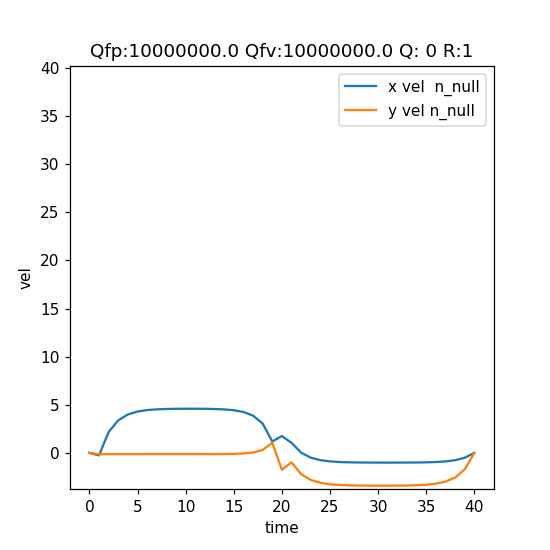

<IPython.core.display.Javascript object>


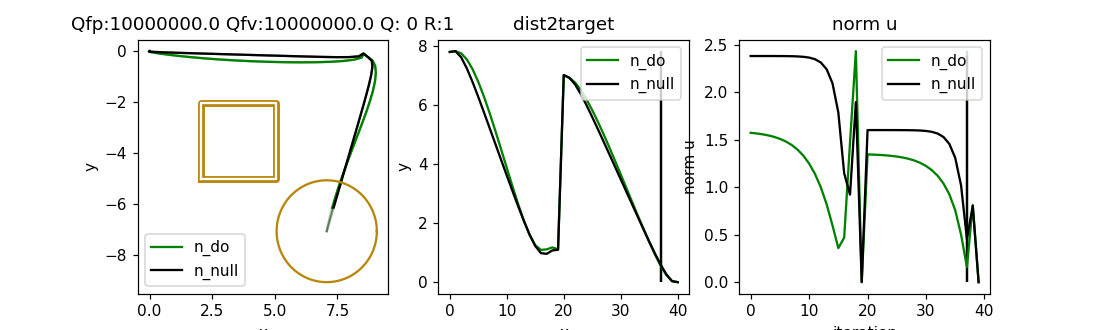

In [528]:
#Plot each on the same subplot
#Visualize results: 
target = 2
task = 1.2 #1.2


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

plt.figure(figsize=(5,5))
#------------------------------------------------------------------
#VELOCITY PLOT:
for i,m in enumerate(['n_null']):#enumerate(model_list): #enumerate(task_models[task]):
    state_da = lqr_sim[target,task,m]['state_da']
    sim_len = lqr_sim[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_vx',:]
    y = state_da.loc['kin_vy',:]        
    plt.plot(x,'-', alpha=1, label='x vel ' +' '+ m) # label=k
    plt.plot(y,'-', alpha=1, label='y vel' +' ' + m)


plt.axis('square')    
plt.xlabel('time')
plt.ylabel('vel')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  


plt.figure(figsize=(10,3))

model_list = ['n_do', 'n_null']
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = lqr_sim[target,task,m]['state_da']
    sim_len = lqr_sim[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 

c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))


# plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):    
    e_da = lqr_sim[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_da,axis=0)
    plt.plot(norm_e,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e.min(), norm_e.max(), color=model_color[m]) #label=k+' done!'

    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = lqr_sim[target,task,m]['u_da']    
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



In [526]:
#Waypoint:
wp = xr.DataArray(move_lqr[target,task]['state_waypoint'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]}, dims = ['v', 'obs'])
wp.loc[kin_var]

<xarray.DataArray (v: 4, obs: 1)>
array([[ 7.778175],
       [ 0.707107],
       [ 7.071068],
       [-7.071068]])
Coordinates:
  * obs      (obs) int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [527]:
#State at waypoint time:
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['h0']['state_da'].loc[kin_var,T-1]

<xarray.DataArray (v: 4)>
array([ 8.73067 , -0.245388,  1.746763, -1.746764])
Coordinates:
    obs      int32 20
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [505]:
#State ERROR at waypoint time:
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['h0']['state_e_da'].loc[kin_var,T-1]

<xarray.DataArray (v: 4)>
array([ 0.952495, -0.952495, -5.324304,  5.324304])
Coordinates:
    obs      int32 20
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [232]:
#State at waypoint time (FULL TRIAL):
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['state_da'].loc[kin_var,T-2]

<xarray.DataArray (v: 4)>
array([-0.094508, -8.539125,  1.189737, -0.843403])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [233]:
#State E at waypoint time (FULL TRIAL):
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['state_e_da'].loc[kin_var,T-2]

<xarray.DataArray (v: 4)>
array([-0.801614, -0.76095 ,  8.260805,  6.227665])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [243]:
#Target:
tp = xr.DataArray(move_lqr[target,task]['state_T'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]}, dims = ['v', 'obs'])
tp.loc[kin_var]

<xarray.DataArray (v: 4, obs: 1)>
array([[-7.071068],
       [-7.071068],
       [ 0.      ],
       [ 0.      ]])
Coordinates:
  * obs      (obs) int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

### Collect all the movement data into a df: 

In [507]:
#start with one movement
target = 2
task = 1.2 #1.2

# target = 7
# task = 1.2
m = 'n_do'
#neural state, cursor state, input, neural "command"

state_da = lqr_sim[target,task,m]['state_da']
u_da = lqr_sim[target,task,m]['u_da']    
state_e_da = lqr_sim[target,task,m]['state_e_da']


In [515]:
#Get neural and kinematic contributions to next kinematic state
n_da = state_da.loc[n_list,:]
Kn_m = np.mat(Kn)
n2k = xr.DataArray(Kn_m*n_da, coords={'v':kin_var+offset_var,'obs':range(n_da.shape[1])}, dims=['v','obs'])

k_da = state_da.loc[kin_var+offset_var,:]
F_m = np.mat(F)
k2k = F_m*k_da

In [516]:
n2k

<xarray.DataArray (v: 5, obs: 41)>
array([[-0.043687,  0.077171,  0.138081, ..., -0.019694, -0.002527, -0.014471],
       [-0.002429, -0.002204, -0.009996, ..., -0.02121 ,  0.090007,  0.00738 ],
       [-0.436868,  0.77171 ,  1.380806, ..., -0.196939, -0.025273, -0.144707],
       [-0.024287, -0.022039, -0.099963, ..., -0.212097,  0.900072,  0.073795],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39 40
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [517]:
khat = n2k+k2k

In [518]:
i=0
khat.loc[:,i]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [519]:
state_da.loc[kin_var+offset_var,i+1]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [498]:
k2k.loc[:,i]

<xarray.DataArray (v: 5)>
array([ 0.017673, -0.011618,  0.176733, -0.116184,  1.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [75]:
n2k.loc[:,i]

<xarray.DataArray (v: 5)>
array([-0.043687, -0.002429, -0.436868, -0.024287,  0.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [105]:
state_da.loc[kin_var+offset_var,i+1]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [76]:
state_da.loc[kin_var+offset_var,i]

<xarray.DataArray (v: 5)>
array([0., 0., 0., 0., 1.])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [34]:
n2k.shape

(5L, 41L)

In [40]:
k2k.shape

(5L, 41L)

In [ ]:
A_list, A_dic, B = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)

In [117]:
state_da.shape

(49L, 41L)

In [118]:
u_da.shape

(44L, 40L)

In [ ]:
#We need to compute Kn*n, so we can bin it.  
#I guess I should split state into two parts, multiply them separately, and recombine to confirm: 

A = lqr_sim[target,]